In [1]:
library(microbiome)
library(phyloseq)
library(ggplot2)
library(tibble)
library(dplyr)

Loading required package: phyloseq

Loading required package: ggplot2


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: 'microbiome'


The following object is masked from 'package:ggplot2':

    alpha


The following object is masked from 'package:base':

    transform



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
metadata_Rew <- read.table(file = "R files/Carbon_analysis/sample-metadata3.txt", sep = "\t", header =  T, skip = 1)
#The first line has column numbers so we use skip =1  to skip that line
#remember to check your sample numbers 
metadata_raw <- read.table(file = "R files/Carbon_analysis/sample-metadata3.txt", sep = "\t", header =  T, skip = 1)%>%
                mutate(sample_ref = sample.id) %>%  
                dplyr::select(-sample_ID) %>%
                tidyr::separate(sample_ref, into = c("read_prefix", "Sample_ID"," replicate_id"), sep =  "[.]") %>%
                mutate(Sample_ID = stringi::stri_replace_last_fixed(Sample_ID, "_", ""))
metadata_sediment <- metadata_raw %>% dplyr::select(sample.id, Sample_ID) 
rownames(metadata_sediment) <- metadata_sediment$sample.id
#list of the 45 samples identifier no replicates
otu_sediment <- read.table(file = "feature-table.tsv", sep = "\t", header = T, row.names = 1, skip = 1, comment.char = "")
tax_sediment_raw <- read.table(file = "taxonomy.tsv", sep = "\t", header = T ,row.names = 1)
tax_sediment <- tax_sediment_raw %>% 
                tidyr::separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = "; ") %>%
                dplyr::mutate(across(1:7, ~ stringr::str_replace_all(.x, "^[dkpcofgs]__",""))) %>%
                dplyr::select(1:7)

Warning message:
"Expected 7 pieces. Missing pieces filled with `NA` in 18661 rows [1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 16, 21, 22, 24, 25, 30, 31, 32, 33, 34, ...]."


In [3]:
OTU_sediment <- otu_table(as.matrix(otu_sediment), taxa_are_rows = TRUE)
TAX_sediment <- tax_table(as.matrix(tax_sediment))
SAMPLE_sediment <- sample_data(metadata_sediment)

In [4]:
(ps_sediment_all <- phyloseq(OTU_sediment, TAX_sediment, SAMPLE_sediment))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48190 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 48190 taxa by 7 taxonomic ranks ]

In [5]:
#water data
metadata_water <-   read.table(file = "water//sample-metadata.tsv", sep = "\t", header =  T) %>%
                    dplyr::mutate(sample_ref = sample.id)  %>%
                    tidyr::separate(sample_ref, into = c("read_prefix", "Sample_ID"), sep =  "[.]") %>%
                    select(sample.id, Sample_ID, estuary.reach,	ecosystem, sediment.water) 
row.names(metadata_water) <- metadata_water$sample.id
otu_water <- read.table(file = "water//feature-table.tsv", sep = "\t", header = T, row.names = 1, skip = 1, comment.char = "")
tax_water_raw <- read.table(file = "water//taxonomy.tsv", sep = "\t", header = T ,row.names = 1)
tax_water <- tax_water_raw %>% 
             tidyr::separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = "; ") %>%
             dplyr::mutate(across(1:7, ~ stringr::str_replace_all(.x, "^[dkpcofgs]__",""))) %>%
             dplyr::select(1:7)

Warning message:
"Expected 7 pieces. Missing pieces filled with `NA` in 1552 rows [1, 2, 4, 5, 6, 8, 12, 13, 15, 16, 17, 19, 20, 24, 25, 26, 27, 28, 29, 30, ...]."


In [6]:
OTU_water <- otu_table(as.matrix(otu_water), taxa_are_rows = TRUE)
TAX_water <- tax_table(as.matrix(tax_water))
SAMPLE_water <- sample_data(metadata_water)

In [7]:
#phyloseq for water
(water_ps <- phyloseq(OTU_water, TAX_water, SAMPLE_water))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3636 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3636 taxa by 7 taxonomic ranks ]

In [8]:
#merge replicates by summing up all readcounts data for the given category
(merged_ps <- merge_samples(ps_sediment_all, "Sample_ID"))

Warning message in asMethod(object):
"NAs introduced by coercion"
Warning message in asMethod(object):
"NAs introduced by coercion"


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 48190 taxa and 45 samples ]
sample_data() Sample Data:       [ 45 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 48190 taxa by 7 taxonomic ranks ]

In [9]:
sample_data(merged_ps) %>% head()

,sample.id,Sample_ID
,<dbl>,<dbl>
LWR_MN1,NA,NA
LWR_MN2,NA,NA
LWR_MN3,NA,NA
LWR_MN4,NA,NA
LWR_MN5,NA,NA
LWR_SG1,NA,NA


In [10]:
#preparing the metadata table
metadata_table <-  metadata_raw %>% 
                   dplyr::select_if(is.character) %>% 
                   dplyr::select(Sample_ID, estuary.reach, ecosystem, sediment.water) %>% 
                   dplyr::mutate_if(is.factor, as.character)  %>%
                   distinct()
row.names(metadata_table) <- metadata_table$Sample_ID

In [11]:
metadata_table %>% head()

,Sample_ID,estuary.reach,ecosystem,sediment.water
,<chr>,<chr>,<chr>,<chr>
LWR_SM1,LWR_SM1,Lower,Saltmarsh,Sediment
LWR_SM2,LWR_SM2,Lower,Saltmarsh,Sediment
LWR_SM3,LWR_SM3,Lower,Saltmarsh,Sediment
LWR_SM4,LWR_SM4,Lower,Saltmarsh,Sediment
LWR_SM5,LWR_SM5,Lower,Saltmarsh,Sediment
LWR_MN1,LWR_MN1,Lower,Mangrove,Sediment


In [12]:
#add sediment metadata as it gets lost during merge
merged_ps <- merge_phyloseq(merged_ps, sample_data(metadata_table))

In [13]:
sample_data(merged_ps) %>% head()

,Sample_ID,sample.id,estuary.reach,ecosystem,sediment.water
,<chr>,<dbl>,<chr>,<chr>,<chr>
LWR_MN1,NA,NA,Lower,Mangrove,Sediment
LWR_MN2,NA,NA,Lower,Mangrove,Sediment
LWR_MN3,NA,NA,Lower,Mangrove,Sediment
LWR_MN4,NA,NA,Lower,Mangrove,Sediment
LWR_MN5,NA,NA,Lower,Mangrove,Sediment
LWR_SG1,NA,NA,Lower,Seagrass,Sediment


In [14]:
#combine sediment and water
nahoon_ps <- merge_phyloseq(merged_ps, water_ps)

In [15]:
#Set up to determine how many phyla to plot using the sediment data
#can change to class
test_ps <- merged_ps %>%
           aggregate_taxa(level = "Phylum") %>%  
           microbiome::transform(transform = "compositional")

In [16]:
#change number top phyla here for the top_n can keep increasing until graph looks untidy
#disable the scientific notation 
options(scipen=999)
(top_phyla <- data.frame(mean_rel = rowMeans(otu_table(test_ps))) %>% tibble::rownames_to_column(var = "Phylum") %>% dplyr::arrange(desc(mean_rel)) %>% top_n(20))

Selecting by mean_rel


Phylum,mean_rel
<chr>,<dbl>
Proteobacteria,0.290406155
Desulfobacterota,0.113285575
Chloroflexi,0.107608890
Planctomycetota,0.101734866
Bacteroidota,0.076392366
Acidobacteriota,0.060803083
Actinobacteriota,0.052099764
Gemmatimonadota,0.019497917
Firmicutes,0.019093303


In [17]:
#use sediment top phyla to filter combined sediment
(ps_subset <- nahoon_ps  %>%
              aggregate_taxa(level = "Phylum") %>%  
              microbiome::transform(transform = "compositional") %>%
              subset_taxa(Phylum %in% top_phyla$Phylum))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 54 samples ]
sample_data() Sample Data:       [ 54 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 3 taxonomic ranks ]

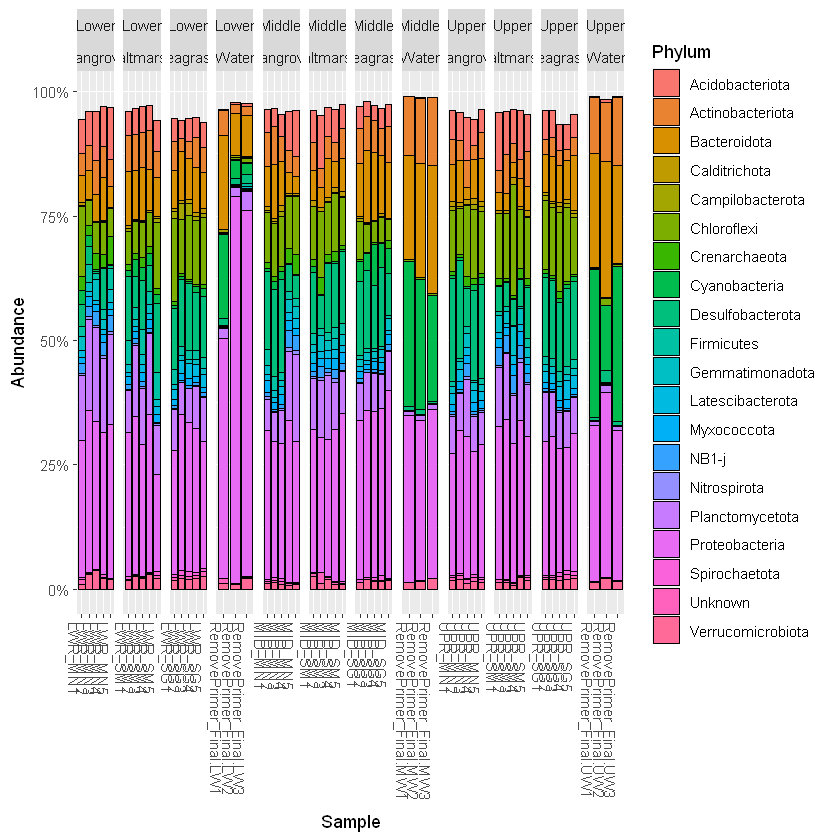

In [18]:
plot_bar(ps_subset, fill = "Phylum") + facet_grid(~ estuary.reach + ecosystem, scale  = "free_x") +
scale_y_continuous(label = scales::percent)
ggsave("composition.pdf", width = 10, height = 7)

In [20]:
##Prevalence is a measurement, which describes in how many samples certain microbes were detected.
#Detection threshold for absence/presence (strictly greater by default).
#aggregate_rare(merged_ps, level = 'Phylum', detection = 0.1/100, prevalence = 5/100)
#https://f1000research.com/articles/5-1492/v2
# Compute prevalence of each feature, store as data.frame
#prevdf = apply(X = otu_table(nahoon_glom_phyla),
                 # MARGIN = ifelse(taxa_are_rows(nahoon_glom_phyla), yes = 1, no = 2),
                 # FUN = function(x){sum(x > 0)})
# Add taxonomy and total read counts to this data.frame
# prevdf = data.frame(Prevalence = prevdf,
#                     Perc_Prev = prevdf/nsamples(nahoon_glom_phyla),
#                     TotalAbundance = taxa_sums(nahoon_glom_phyla),
#                     PercAbundance =  taxa_sums(nahoon_glom_phyla)/sum(taxa_sums(nahoon_glom_phyla)),
#                     tax_table(nahoon_glom_phyla))